In [1]:
# import the required modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import pearsonr

In [2]:
# load the required dataset
# first load the observation data (ERA5)
obs = xr.open_dataset("/home/users/benhutch/ERA5_psl/nao-anomaly/nao-anomaly-ERA5.8yrRM.nc", chunks={"time": 10})
# load the obs dataset which subtracts the multi-model mean basline
# thats not it
# obs_hindcast_bl = xr.open_dataset("/home/users/benhutch/ERA5_psl/nao-anomaly/nao-anomaly-ERA5-hindcast-BL.8yrRM.nc", chunks={"time": 10})

# load the model data for all models
# already pre-processed to multi-model mean
model = xr.open_dataset("/home/users/benhutch/multi-model/multi-model.mean-NAO.nc", chunks={"time": 10})


In [3]:

# Import the individual files
# not-lagged!
# combined into models - first stream of development
# Directory containing the files
data_dir = "/home/users/benhutch/multi-model/model-results"

# List of file names
files = [
    "nao-anomaly-BCC-CSM2-MR.nc",
    "nao-anomaly-CanESM5.nc",
    "nao-anomaly-CESM1-1-CAM5-CMIP5.nc",
    "nao-anomaly-CMCC-CM2-SR5.nc",
    "nao-anomaly-EC-Earth3.nc",
    "nao-anomaly-FGOALS-f3-L.nc",
    "nao-anomaly-HadGEM3-GC31-MM.nc",
    "nao-anomaly-IPSL-CM6A-LR.nc",
    "nao-anomaly-MIROC6.nc",
    "nao-anomaly-MPI-ESM1-2-HR.nc",
    "nao-anomaly-MPI-ESM1-2-LR.nc",
    "nao-anomaly-NorCPM1.nc",
]

# Generate dataset names by removing the 'nao-anomaly-' prefix and the '.nc' extension
dataset_names = [file.replace("nao-anomaly-", "").replace(".nc", "") for file in files]

# Import the files using xarray and create a dictionary of datasets with separate names
datasets = {name: xr.open_dataset(os.path.join(data_dir, file), chunks={'time': 10}) 
            for name, file in zip(dataset_names, files)}

In [ ]:
# import the lagged nao-anomaly files
# Directory containing the files
data_dir = "/home/users/benhutch/multi-model/lagged-model-results"

# list of file names
files = [
    "nao-anomaly-BCC-CSM2-MR-ensemble-mean.nc",
    "nao-anomaly-CanESM5-ensemble-mean.nc",
    "nao-anomaly-CESM1-1-CAM5-CMIP5-ensemble-mean.nc",
    "nao-anomaly-CMCC-CM2-SR5-ensemble-mean.nc",
    "nao-anomaly-EC-Earth3-ensemble-mean.nc",
    "nao-anomaly-FGOALS-f3-L-ensemble-mean.nc",
    "nao-anomaly-HadGEM3-GC31-MM-ensemble-mean.nc",
    "nao-anomaly-IPSL-CM6A-LR-ensemble-mean.nc",
    "nao-anomaly-MIROC6-ensemble-mean.nc",
    "nao-anomaly-MPI-ESM1-2-HR-ensemble-mean.nc",
    "nao-anomaly-MPI-ESM1-2-LR-ensemble-mean.nc",
    "nao-anomaly-multi-model-ensemble-mean.nc",
    "nao-anomaly-NorCPM1-ensemble-mean.nc",
]

# Generate dataset names by removing the 'nao-anomaly-' prefix and the '-ensemble-mean.nc' extension
lagged_dataset_names = [file.replace("nao-anomaly-", "").replace("-ensemble-mean.nc", "") for file in files]

# Import the files using xarray and create a dictionary of datasets with separate names#
lagged_datasets = {name: xr.open_dataset(os.path.join(data_dir, file), chunks={'time': 10}) for name, file in zip(lagged_dataset_names, files)}


In [4]:
datasets['NorCPM1']

<xarray.Dataset>
Dimensions:    (time: 55, bnds: 2, lon: 1, lat: 1)
Coordinates:
  * time       (time) object 1965-08-01 00:00:00 ... 2019-08-01 00:00:00
  * lon        (lon) float64 0.0
  * lat        (lat) float64 0.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    psl        (time, lat, lon) float32 dask.array<chunksize=(10, 1, 1), meta=np.ndarray>
Attributes: (12/53)
    CDI:                       Climate Data Interface version 2.0.4 (https://...
    source:                    NorCPM1 (2019): \naerosol: OsloAero4.1 (same g...
    institution:               NorESM Climate modeling Consortium consisting ...
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               DCPP
    branch_method:             standard
    ...                        ...
    variable_id:               psl
    variant_label:             r10i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/0dbd181c-4d62-4885-b5cc-52ce056427a3
    CDO:                       Climate Data Operators version 2.0.4 (https://...

In [5]:
# define a function to process each of the model datasets
def process_model_dataset(dataset):
    """
    Processes the dataset by extracting the desired data, converting units,
    and setting the time variable's data type.

    Parameters:
    dataset (xarray.Dataset): The input dataset

    Returns:
    numpy.ndarray: The model_time array
    numpy.ndarray: The model_nao_anom array
    """

    # Extract the data for the model
    model_psl = dataset["psl"]
    model_time = model_psl["time"].values

    # Set the type for the time variable
    model_time = model_time.astype("datetime64[Y]")

    # Process the model data from Pa to hPa
    model_nao_anom = model_psl[:, 0, 0] / 100

    return model_time, model_nao_anom

In [6]:
# Assuming `datasets` is the dictionary containing the imported datasets

# Apply the process_model_dataset function to each dataset in the dictionary
model_times, model_nao_anoms = zip(*[process_model_dataset(ds) for ds in datasets.values()])

# process the lagged datasets
# using the process_model_dataset function
lagged_model_times, lagged_model_nao_anoms = zip(*[process_model_dataset(ds) for ds in lagged_datasets.values()])

In [7]:
# now shift the model nao back by one year
# and remove the last year of data
def shift_model_nao_anom(model_nao_anom):
    """
    Shifts the model_nao_anom array back by one year and removes the last year of data
    to avoid wraparound effects.

    Parameters:
    model_nao_anom (numpy.ndarray): The input model_nao_anom array

    Returns:
    numpy.ndarray: The shifted model_nao_anom array
    """

    # Shift model_nao_anom data back by 1 year
    shifted_model_nao_anom = np.roll(model_nao_anom[:-4], -1)

    # Remove the last year of data to avoid wraparound effects
    shifted_model_nao_anom = shifted_model_nao_anom[:-1]

    return shifted_model_nao_anom

In [8]:
# run this function
# Assuming `model_nao_anoms` is the tuple containing the model_nao_anom arrays

# Apply the shift_model_nao_anom function to each model_nao_anom array in the tuple
shifted_model_nao_anoms = tuple(shift_model_nao_anom(model_nao_anom) for model_nao_anom in model_nao_anoms)

# now shift the lagged model nao back by one year
# and remove the last year of data
lagged_shifted_model_nao_anoms = tuple(shift_model_nao_anom(model_nao_anom) for model_nao_anom in lagged_model_nao_anoms)

In [9]:
# extract the data for the observations
obs_psl = obs["var151"]
obs_time = obs_psl["time"].values
# set the type for the time variable
obs_time = obs_time.astype("datetime64[Y]")

# process the obs data from Pa to hPa
obs_nao_anom = obs_psl[:, 0, 0] / 100

In [11]:
# extract the data for the multi-model mean
model_psl = model["psl"]
model_time = model_psl["time"].values
# set the type for the time variable
model_time = model_time.astype("datetime64[Y]")

# process the model data from Pa to hPa
model_nao_anom = model_psl[:, 0, 0] / 100

In [ ]:
print(obs_time)
print(obs_bl_time)
print(model_time)

In [ ]:
print(obs_time[3:-5])
print(obs_bl_time[3:-5])
print(model_time[:-9])

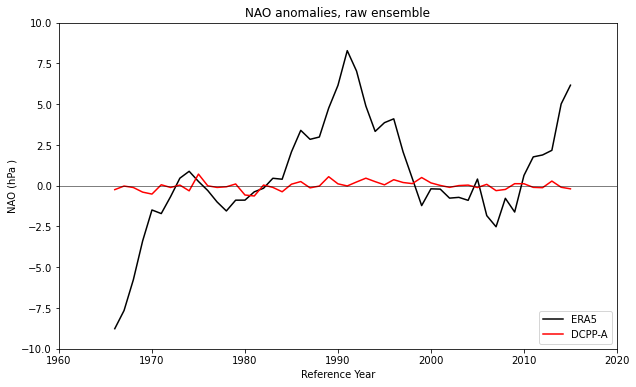

In [12]:
# plot the evolution of the NAO index with time
# first create the figure
fig = plt.figure(figsize=(10, 6))
# add the axes
ax = fig.add_subplot(111)
# plot the data
# now aligned, but still looks very slightly off compared to Doug's plot and Andrea's plot
# perhaps something to ask doug down the line
ax.plot(obs_time[3:], obs_nao_anom[3:], color="black", label="ERA5")
#ax.plot(obs_bl_time[3:], obs_bl_nao_anom[3:], color="black", label="ERA5 hindcast BL", linestyle="--")
ax.plot(model_time[:-4], model_nao_anom[:-4], color="red", label="DCPP-A")
ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
# set the x-axis limits
ax.set_xlim([np.datetime64("1960"), np.datetime64("2020")])
# set the y-axis limits
ax.set_ylim([-10, 10])
# set the x-axis label
ax.set_xlabel("Reference Year")
# set the y-axis label
ax.set_ylabel("NAO (hPa )")
# set the title
ax.set_title("NAO anomalies, raw ensemble")
# add the legend in the bottom right corner
ax.legend(loc="lower right")
# save the figure
plt.savefig("/home/users/benhutch/multi-model/plots/nao-anomaly-raw.png", dpi=300)
# show the figure
plt.show()


In [13]:
# Calculate the ACC and p-value
# cutoff 2010 - short period
ACC, p_value = pearsonr(obs_nao_anom[3:-5], model_nao_anom[:-9])
print("Anomaly Correlation Coefficient (ACC):", ACC)
print("P-value:", p_value)

Anomaly Correlation Coefficient (ACC): 0.39622496111567285
P-value: 0.0070510087848265676


In [14]:
# Shift model_nao_anom data back by 1 years
shifted_model_nao_anom = np.roll(model_nao_anom[:-4], -1)

# Remove the last year of data to avoid wraparound effects
shifted_model_nao_anom = shifted_model_nao_anom[:-1]

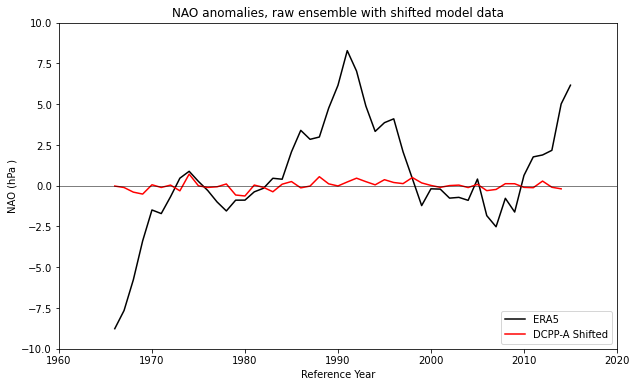

In [17]:
# now plot this
# Plot the evolution of the NAO index with time
# First create the figure
fig = plt.figure(figsize=(10, 6))
# Add the axes
ax = fig.add_subplot(111)
# Plot the data
ax.plot(obs_time[3:], obs_nao_anom[3:], color="black", label="ERA5")
ax.plot(model_time[:-5], shifted_model_nao_anom, color="red", label="DCPP-A Shifted")
ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
# Set the x-axis limits
ax.set_xlim([np.datetime64("1960"), np.datetime64("2020")])
# Set the y-axis limits
ax.set_ylim([-10, 10])
# Set the x-axis label
ax.set_xlabel("Reference Year")
# Set the y-axis label
ax.set_ylabel("NAO (hPa )")
# Set the title
ax.set_title("NAO anomalies, raw ensemble with shifted model data")
# Add the legend in the bottom right corner
ax.legend(loc="lower right")
# Save the figure
plt.savefig("/home/users/benhutch/multi-model/plots/nao-anomaly-shifted.png", dpi=300)
# Show the figure
plt.show()

In [19]:
print(model_time[:-5])

['1966' '1967' '1968' '1969' '1970' '1971' '1972' '1973' '1974' '1975'
 '1976' '1977' '1978' '1979' '1980' '1981' '1982' '1983' '1984' '1985'
 '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994' '1995'
 '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005'
 '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014']


In [13]:
# now calculate full field skill score for this
# Calculate the ACC and p-value with the shifted data
ACC_shifted, p_value_shifted = pearsonr(obs_nao_anom[3:-1], shifted_model_nao_anom)
print("Anomaly Correlation Coefficient (ACC) with shifted data:", ACC_shifted)
print("P-value with shifted data:", p_value_shifted)


Anomaly Correlation Coefficient (ACC) with shifted data: 0.41161140706869653
P-value with shifted data: 0.003299467320875538


In [14]:
# now calculate long time period (1960-2010) skill scores for this
ACC_shifted_long, p_value_shifted_long = pearsonr(obs_nao_anom[3:-6], shifted_model_nao_anom[:-5])
print("Anomaly Correlation Coefficient (ACC) with shifted data:", ACC_shifted_long)
print("P-value with shifted data:", p_value_shifted_long)

Anomaly Correlation Coefficient (ACC) with shifted data: 0.4551747440821704
P-value with shifted data: 0.0019061798889212363


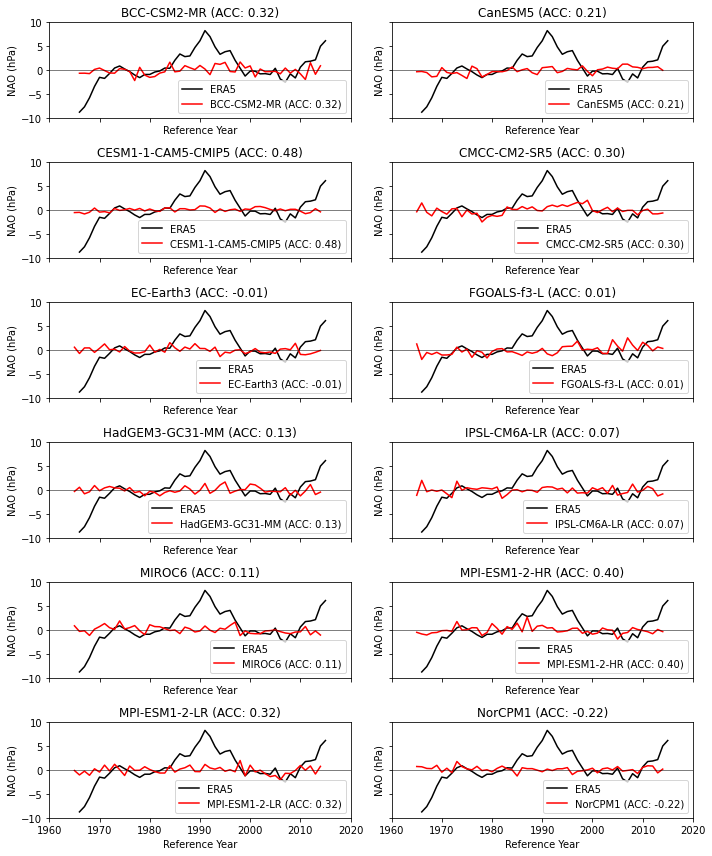

In [21]:
# plot each of the individual subplots
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming `obs_time` and `obs_nao_anom` are the observation data
# Assuming `model_times` and `shifted_model_nao_anoms` are tuples containing the model times and shifted model NAO anomalies, respectively
# Assuming `dataset_names` is a list containing the names of the datasets

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (model_time, shifted_model_nao_anom, name) in enumerate(zip(model_times, shifted_model_nao_anoms, dataset_names)):
    ax = axes[i]

    # Calculate the ACC score
    if name == "BCC-CSM2-MR":
        # BCC model starts in 1961, so adjust the indices accordingly
        acc_score, _ = pearsonr(obs_nao_anom[3:-6], shifted_model_nao_anom[:-5])
    else:
        # Other models start in 1960
        acc_score, _ = pearsonr(obs_nao_anom[2:-6], shifted_model_nao_anom[:-5])

    # Plot the data
    ax.plot(obs_time[3:], obs_nao_anom[3:], color="black", label="ERA5")
    ax.plot(model_time[:-5], shifted_model_nao_anom, color="red", label=f"{name} (ACC: {acc_score:.2f})")

    ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    ax.set_xlim([np.datetime64("1960"), np.datetime64("2020")])
    ax.set_ylim([-10, 10])
    ax.set_xlabel("Reference Year")
    ax.set_ylabel("NAO (hPa)")

    # Set the title
    ax.set_title(f"{name} (ACC: {acc_score:.2f})")

    # Add the legend in the bottom right corner
    ax.legend(loc="lower right")

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig("/home/users/benhutch/multi-model/plots/nao-anomaly-shifted-subplots.png", dpi=300)

# Show the figure
plt.show()

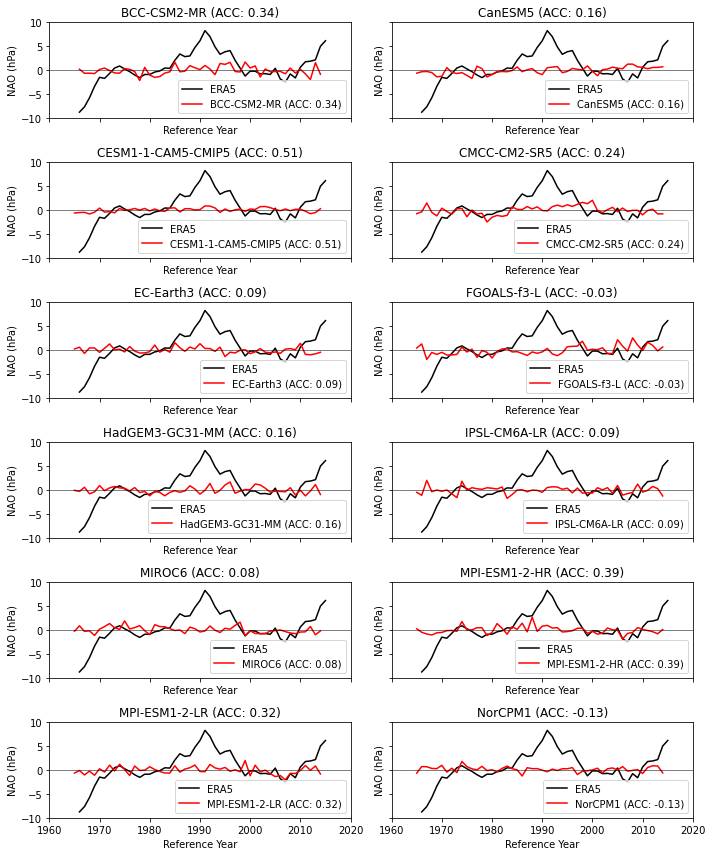

In [22]:
# Assuming `obs_time` and `obs_nao_anom` are the observation data
# Assuming `model_times` and `model_nao_anoms` are tuples containing the model times and original model NAO anomalies, respectively
# Assuming `dataset_names` is a list containing the names of the datasets

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (model_time, model_nao_anom, name) in enumerate(zip(model_times, model_nao_anoms, dataset_names)):
    ax = axes[i]

    # Calculate the ACC score
    if name == "BCC-CSM2-MR":
        # BCC model starts in 1961, so adjust the indices accordingly
        acc_score, _ = pearsonr(obs_nao_anom[3:-5], model_nao_anom[:-9])
    else:
        # Other models start in 1960
        acc_score, _ = pearsonr(obs_nao_anom[2:-5], model_nao_anom[:-9])

    # Plot the data
    ax.plot(obs_time[3:], obs_nao_anom[3:], color="black", label="ERA5")
    ax.plot(model_time[:-5], model_nao_anom[:-5], color="red", label=f"{name} (ACC: {acc_score:.2f})")

    ax.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    ax.set_xlim([np.datetime64("1960"), np.datetime64("2020")])
    ax.set_ylim([-10, 10])
    ax.set_xlabel("Reference Year")
    ax.set_ylabel("NAO (hPa)")

    # Set the title
    ax.set_title(f"{name} (ACC: {acc_score:.2f})")

    # Add the legend in the bottom right corner
    ax.legend(loc="lower right")

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig("/home/users/benhutch/multi-model/plots/nao-anomaly-original-subplots.png", dpi=300)

# Show the figure
plt.show()


In [ ]:
# define a function to adjust the variance of the model data to match the observations
def adjust_variance(observation, model_nao):
    # Calculate the ensemble mean for all start times
    y_hat = np.mean(model_nao)

    # Calculate the observed variance and correlation coefficient
    sigma_obs = np.var(observation)
    r = np.corrcoef(observation, model_nao)[0, 1]

    # Calculate the signal variance
    sigma_sig = np.var(model_nao)

    # Adjust the ensemble mean using the provided equation
    adjusted_model_nao = (model_nao - y_hat) * (sigma_obs * r / sigma_sig) + y_hat

    return adjusted_model_nao

In [ ]:
print(np.shape(obs_nao_anom))
print(np.shape(lagged_model_nao_anoms))
print(obs_time)
print(lagged_model_times)

In [ ]:
# extract the overlapping data for eahc model
# then apply the adjust variance for each model
adjusted_lagged_model_nao_anoms = []

# for lagged model NAO anoms, adjust the variance
for i, model_nao_anom in enumerate(lagged_model_nao_anoms):
    # Extract overlapping data
    obs_overlap = obs_nao_anom[np.isin(obs_time, common_time_range[i])]
    model_overlap = model_nao_anom[np.isin(lagged_model_times[i], common_time_range[i])]

    print(obs_nao_anom)
    print(model_nao_anom)
    print(obs_overlap)
    print(model_overlap)
    
    # Adjust the variance using the overlapping data
    adjusted_model_nao_anom = adjust_variance(obs_overlap, model_overlap)

    # Store the adjusted model NAO anomalies
    adjusted_lagged_model_nao_anoms.append(adjusted_model_nao_anom)

print(np.shape(adjusted_lagged_model_nao_anoms)) # 1969 - 2015

# init empty array to store shifted, lagged, var adjustred NAO anoms
shifted_adjusted_lagged_model_nao_anoms = []

print(np.shape(lagged_shifted_model_nao_anoms))
print(lagged_shifted_model_nao_anoms)

# for lagged shifted model NAO anoms, adjust the variance
for i, model_nao_anom in enumerate(lagged_shifted_model_nao_anoms):
    # Extract overlapping data
    obs_overlap = obs_nao_anom[np.isin(obs_time, common_time_range[i])]
    model_overlap = model_nao_anom[np.isin(lagged_model_times[i], common_time_range[i])]

    # print the shapes of the overlapping data for debugging
    print(np.shape(obs_overlap))
    print(np.shape(model_overlap))
    print(np.shape(obs_nao_anom))
    print(np.shape(model_nao_anom))

    # Adjust the variance using the overlapping data
    adjusted_model_nao_anom = adjust_variance(obs_overlap, model_overlap)

    # Store the adjusted model NAO anomalies
    shifted_adjusted_lagged_model_nao_anoms.append(adjusted_model_nao_anom)

print(np.shape(shifted_adjusted_lagged_model_nao_anoms)) # 1969 - 2015 shifted
